In [1]:
# IMPORT LIBRARIES / FORMATTING
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from textwrap import wrap

# CUSTOMIZE DISPLAY SETTINGS
sns.set_theme()
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams.update({'font.size': 11, 'axes.titlepad': 10})
palette = sns.color_palette('deep')

# IGNORE PANDAS WARNING
pd.options.mode.chained_assignment = None

In [2]:
# READ IN DATA
trans = pd.read_csv('datasets/transactions_data.csv')
users = pd.read_csv('datasets/users_data.csv')
cards = pd.read_csv('datasets/cards_data.csv')
mcc_codes = pd.read_json('datasets/mcc_codes.json', typ='series')
fraud_labels = pd.read_json('datasets/train_fraud_labels.json')

# MERGE CARD + USER DATAFRAMES
trans = trans.rename(columns={'id': 'transaction_id'})
card_cols_to_merge = ['id', 'card_brand', 'card_type', 'credit_limit']
user_cols_to_merge = ['id', 'current_age', 'gender', 'yearly_income', 'credit_score']
trans = trans.merge(cards[card_cols_to_merge], left_on='card_id', right_on='id')
trans = trans.merge(users[user_cols_to_merge], left_on='client_id', right_on='id')

# MERGE MCC INFO
mcc_codes.name = 'merchant_type'
mcc_codes = mcc_codes.to_frame()
trans = trans.merge(mcc_codes, left_on='mcc', right_index=True)

# MERGE FRAUD LABELS
fraud_labels['target'].value_counts()
trans = trans.merge(fraud_labels, left_on='transaction_id', right_index=True)
trans = trans.rename(columns={'target': 'fraud'})

# CLEAN CURRENCY COLUMNS
trans['amount'] = trans['amount'].str.replace('$', '', regex=True).astype(float)
trans['credit_limit'] = trans['credit_limit'].str.replace('$', '', regex=True).astype(int)
trans['yearly_income'] = trans['yearly_income'].str.replace('$', '', regex=True).astype(int)

# CREATE MONTH AND YEAR COLUMNS
trans['date'] = pd.to_datetime(trans['date'])
trans['month'] = trans['date'].dt.month
trans['year'] = trans['date'].dt.year

# DROP UNNECCESSARY COLUMNS
trans = trans.drop(
    columns=[
        'transaction_id',
        'date',
        'client_id',
        'card_id',
        'merchant_id',
        'mcc',
        'id_x',
        'id_y',
        'card_id',
        'client_id',
        'zip',
        'mcc',
    ]
)

trans.head()

,amount,use_chip,merchant_city,merchant_state,errors,card_brand,card_type,credit_limit,current_age,gender,yearly_income,credit_score,merchant_type,fraud,month,year
0,-77.00,Swipe Transaction,Beulah,ND,NaN,Mastercard,Debit (Prepaid),55,30,Female,48277,740,Miscellaneous Food Stores,No,1,2010
2,39.63,Swipe Transaction,Beulah,ND,NaN,Mastercard,Debit (Prepaid),55,30,Female,48277,740,Miscellaneous Food Stores,No,1,2010
20,-74.00,Swipe Transaction,Beulah,ND,NaN,Mastercard,Debit (Prepaid),55,30,Female,48277,740,Miscellaneous Food Stores,No,1,2010
21,74.00,Swipe Transaction,Beulah,ND,NaN,Mastercard,Debit (Prepaid),55,30,Female,48277,740,Miscellaneous Food Stores,No,1,2010
34,82.00,Swipe Transaction,Beulah,ND,NaN,Mastercard,Debit (Prepaid),55,30,Female,48277,740,Miscellaneous Food Stores,No,2,2010


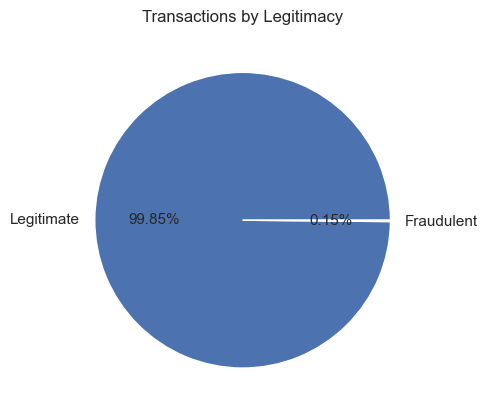

In [3]:
# [ANALYSIS] What percentage of total transactions were fraudulent? --> 0.15%
fraud_transactions = trans[trans['fraud'] == 'Yes']
trans['fraud'].value_counts(normalize='Yes').mul(100)

values = trans['fraud'].value_counts().values
plt.title('Transactions by Legitimacy')
plt.pie(
    values,
    labels=['Legitimate', 'Fraudulent'],
    autopct='%1.2f%%',
    textprops={'fontsize': 11},
)
plt.show()

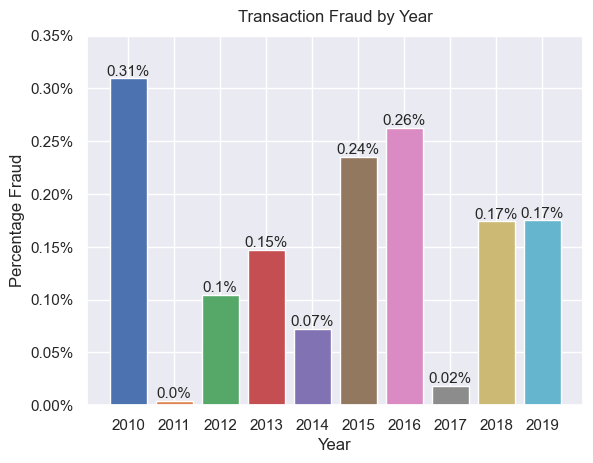

In [4]:
# [ANALYSIS] Which YEAR had the highest percentage of fraud? --> 2010 (0.31%)
fraud_by_year = trans.groupby('year')['fraud'].value_counts(normalize=True).mul(100)
fraud_by_year = fraud_by_year.to_frame('percent_fraud').reset_index()
keys = fraud_by_year[fraud_by_year['fraud'] == 'Yes']['year']
values = fraud_by_year[fraud_by_year['fraud'] == 'Yes']['percent_fraud']

fig, ax1 = plt.subplots()
ax1.bar(keys, values, color=palette)
ax1.set(xlabel='Year', ylabel='Percentage Fraud', title='Transaction Fraud by Year', xticks=keys)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}%'))
ax1.set_ylim(top=0.35)

# Annotate values for each bar
for bar in ax1.patches:
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        str(round(bar.get_height(), 2)) + '%',
        ha='center',
        va='bottom',
    )

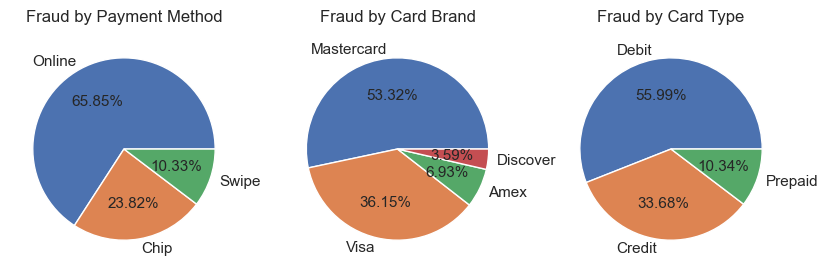

In [5]:
# [ANALYSIS] How did fraud differ by PAYMENT METHOD, CARD BRAND, and CARD TYPE?
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Plot 1: Fraud By PAYMENT METHOD
ax1.set_title('Fraud by Payment Method')
swipe_values = fraud_transactions['use_chip'].value_counts().values
swipe_labels = fraud_transactions['use_chip'].value_counts().keys().to_list()
swipe_labels = [i.replace(' Transaction', '') for i in swipe_labels]

# Plot 2: Fraud by CARD BRAND
ax2.set_title('Fraud by Card Brand')
card_brand_values = fraud_transactions['card_brand'].value_counts().values
card_brand_labels = fraud_transactions['card_brand'].value_counts().keys().to_list()

# Plot 3: Fraud by CARD TYPE
ax3.set_title('Fraud by Card Type')
card_type_values = fraud_transactions['card_type'].value_counts().values
card_type_labels = fraud_transactions['card_type'].value_counts().keys().to_list()
card_type_labels[2] = 'Prepaid'

ax1.pie(
    swipe_values,
    labels=swipe_labels,
    autopct='%.2f%%',
    textprops={'fontsize': 11},
)
ax2.pie(
    card_brand_values,
    labels=card_brand_labels,
    autopct='%.2f%%',
    textprops={'fontsize': 11},
)
ax3.pie(
    card_type_values,
    labels=card_type_labels,
    autopct='%.2f%%',
    textprops={'fontsize': 11},
)

plt.show()

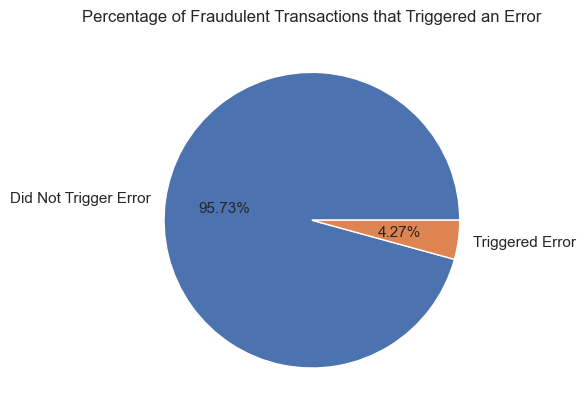

In [6]:
# [ANALYSIS] What percentage of fraudlent transactions triggered an error? --> 4.27%
triggered_error = trans[(trans['fraud'] == 'Yes')]['errors'].count()
no_error = trans[trans['fraud'] == 'Yes']['errors'].isnull().sum()

plt.title('Percentage of Fraudulent Transactions that Triggered an Error')
plt.pie(
    [no_error, triggered_error],
    labels=['Did Not Trigger Error', 'Triggered Error'],
    autopct='%.2f%%',
    textprops={'fontsize': 11},
)
plt.show()

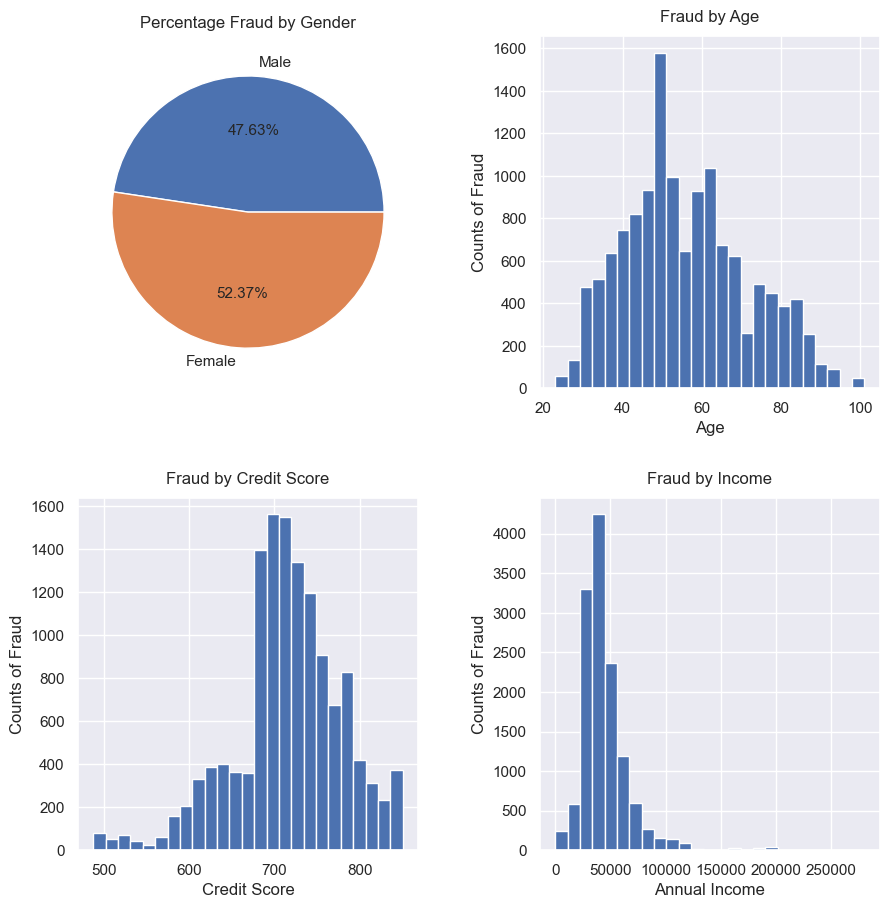

In [7]:
# [ANALYSIS] Visualize demographics (GENDER, AGE, CREDIT SCORE, INCOME) of frauded customers
gender = fraud_transactions.groupby('fraud')['gender'].value_counts()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5)

# Plot 1: Fraud by GENDER
ax1.set_title('Percentage Fraud by Gender')
ax1.pie(
    [gender['Yes']['Male'], gender['Yes']['Female']],
    labels=['Male', 'Female'],
    autopct='%.2f%%',
)

# Plot 2: Fraud by AGE
ax2.hist(fraud_transactions['current_age'], bins=25)
ax2.set(xlabel='Age', ylabel='Counts of Fraud', title='Fraud by Age')

# Plot 3: Fraud by CREDIT SCORE
ax3.hist(fraud_transactions['credit_score'], bins=25)
ax3.set(xlabel='Credit Score', ylabel='Counts of Fraud', title='Fraud by Credit Score')

# Plot 4: Fraud by ANNUAL INCOME
ax4.hist(fraud_transactions['yearly_income'], bins=25)
ax4.set(xlabel='Annual Income', ylabel='Counts of Fraud', title='Fraud by Income')

plt.show()

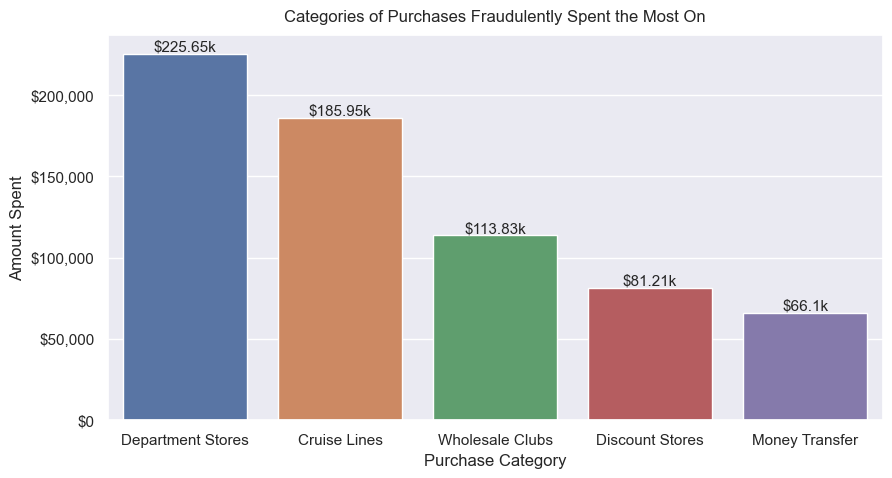

In [8]:
# [ANALYSIS] What types of purchases were fraudulent transactions most spent on?
fraud_top_5 = fraud_transactions.groupby('merchant_type')['amount'].agg(['sum'])
fraud_top_5 = fraud_top_5.sort_values('sum',ascending=False).reset_index().head(5)

fig, ax1 = plt.subplots(figsize=(10,5))
ax1 = sns.barplot(fraud_top_5, x='merchant_type', y='sum')
ax1.set(
    xlabel='Purchase Category',
    ylabel='Amount Spent',
    title='Categories of Purchases Fraudulently Spent the Most On',
)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Annotate values for each bar
for bar in ax1.patches:
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        '$' + str(round(float(bar.get_height()/1000),2)) + 'k',
        ha='center',
        va='bottom',
    )

In [9]:
# Function to map month to corresponding season
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Create new column for season
trans['season'] = trans['month'].apply(get_season)

In [10]:
# Create groupbys for analysis
by_year = trans.groupby(['year'])['amount'].agg([np.mean, np.sum]).reset_index()
by_season = trans.groupby(['season'])['amount'].agg([np.mean, np.sum]).reset_index()
by_merchant = trans.groupby(['merchant_type'])['amount'].agg([np.mean, np.sum]).reset_index()
by_state = trans.groupby(['merchant_state'])['amount'].agg([np.mean, np.sum]).reset_index()

# Function to format y-axis labels
def millions_formatter(x, pos):
    return f'${x / 1000000:.0f}M'

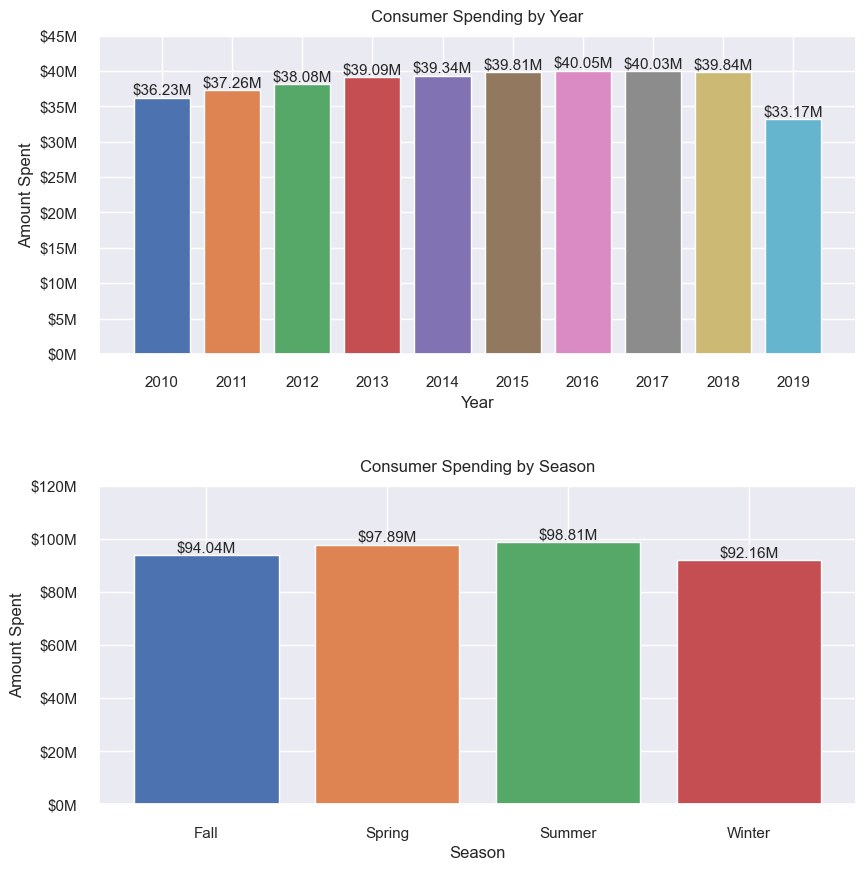

In [11]:
# [ANALYSIS] Visualize consumer spending by YEAR and SEASON
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout(pad=6.5)

# Plot 1: Amount spent by YEAR
ax1.bar(by_year['year'], by_year['sum'], color=palette)
ax1.set(xlabel='Year', ylabel='Amount Spent', title='Consumer Spending by Year', xticks=by_year['year'])
ax1.set_ylim(0, 45000000)

# Plot 2: Amount spent by SEASON
ax2.bar(by_season['season'], by_season['sum'], color=palette)
ax2.set(xlabel='Season', ylabel='Amount Spent', title='Consumer Spending by Season')
ax2.set_ylim(0, 120000000)

# Annotate values for each bar
for ax in fig.axes:
    ax.ticklabel_format(axis='y', style='plain')
    ax.tick_params(pad=10)
    for bar in ax.patches:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height(),
            '$' + str(round(float(bar.get_height() / 1000000), 2)) + 'M',
            ha='center',
            va='bottom',
        )

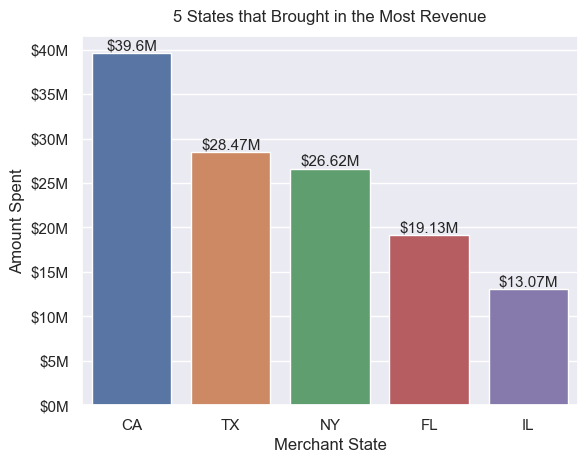

In [14]:
# [ANALYSIS] Which MERCHANT STATES were responsible for bringing in the most revenue? --> CA, TX, NY, FL, IL
fig, ax1 = plt.subplots()
ax1 = sns.barplot(by_state.sort_values('sum', ascending=False).head(5), x='merchant_state', y='sum')
ax1.set(
    xlabel='Merchant State',
    ylabel='Amount Spent',
    title='5 States that Brought in the Most Revenue',
)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Annotate values for each bar
for bar in ax1.patches:
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        '$' + str(round(float(bar.get_height() / 1000000), 2)) + 'M',
        ha='center',
        va='bottom',
    )

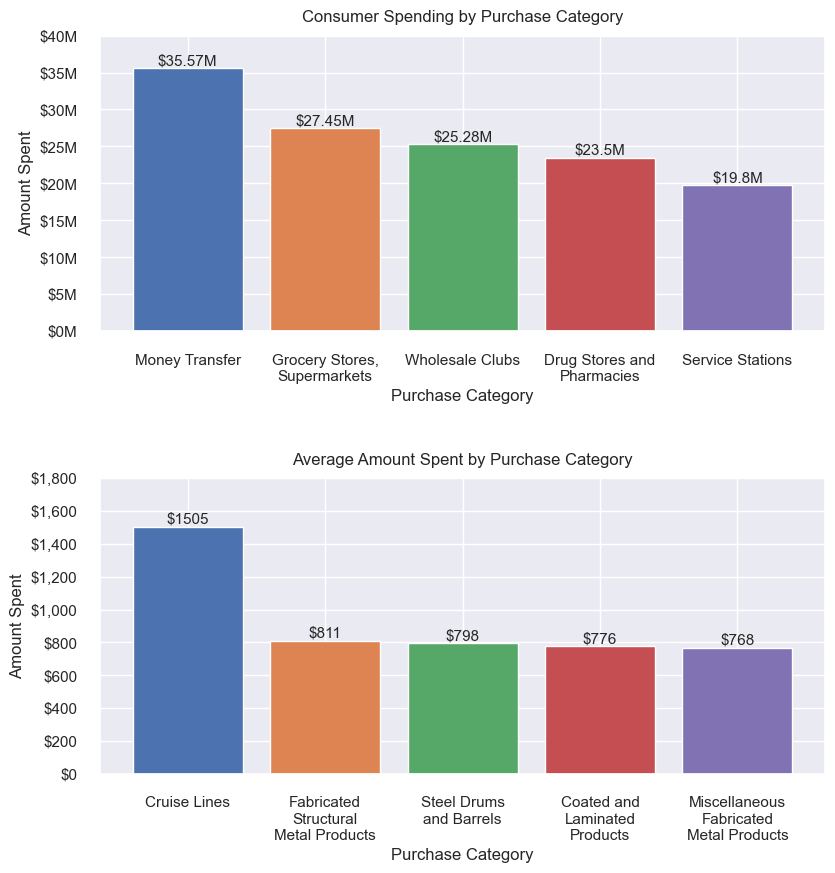

In [13]:
# [ANALYSIS] Visualize total amount and average amount spent by MERCHANT TYPE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout(pad=7.5)

# Plot 1: Total amount spent
keys = by_merchant.sort_values('sum', ascending=False).head(5)['merchant_type']
values = by_merchant.sort_values('sum', ascending=False).head(5)['sum']
ax1.bar(keys, values, color=palette)
ax1.set(xlabel='Purchase Category', ylabel='Amount Spent', title='Consumer Spending by Purchase Category')
ax1.set_ylim(top=40000000)

# Wrap labels (x-axis)
labels = ['\n'.join(wrap(l, 20)) for l in keys]  # Wrap x-axis labels
ax1.set_xticks(keys)
ax1.set_xticklabels(labels)

# Plot 2: Average amount spent
keys = by_merchant.sort_values('mean', ascending=False).head(5)['merchant_type']
values = by_merchant.sort_values('mean', ascending=False).head(5)['mean']
ax2.bar(keys, values, color=palette)
ax2.set(xlabel='Purchase Category', ylabel='Amount Spent', title='Average Amount Spent by Purchase Category')
ax2.set_ylim(top=1800)

# Wrap labels (x-axis)
labels = ['\n'.join(wrap(l, 14)) for l in keys]
ax2.set_xticks(keys)
ax2.set_xticklabels(labels)

# Annotate values for each bar
for i, ax in enumerate(fig.axes):
    ax.ticklabel_format(axis='y', style='plain')
    ax.tick_params(pad=10)
    for bar in ax.patches:
        if i == 0:
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height(),
                '$' + str(round(float(bar.get_height() / 1000000), 2)) + 'M',
                ha='center',
                va='bottom',
            )
        elif i == 1:
            ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height(),
                '$' + str(int(bar.get_height())),
                ha='center',
                va='bottom',
            )